## **1. Data Acquisition**

In [ ]:
# Importing necessary libraries for NHL data scraping and processing
import requests
import pandas as pd
import re
import numpy as np
from datetime import datetime, timedelta
import time
import json
import os
from typing import Dict

**Code below defines base URL, and other key attributes like number of games, game type (regular season vs playoff), amongst other options.**

In [ ]:
# Key constants for NHL API
BASE_URL = "https://api-web.nhle.com/v1/gamecenter/"
years = [str(year) for year in range(2016, 2024)]  # range of seasons from 2016 to 2024
game_type = {'regular_season': '02', 'playoffs': '03'}  # game types
# Map the number of games for each season for regular season
num_games = {
    '2016': 1230, '2017': 1271, '2018': 1271, '2019': 1082,
    '2020': 868, '2021': 1312, '2022': 1312, '2023': 1312
}
# Generate game IDs for each season
game_ids = {year: [f"{year}{game_type['regular_season']}{str(game).zfill(4)}" for game in range(1, num_games[year] + 1)] for year in years}
num_rounds = 4
num_games_playoffs = 7
number_series = {1 : 8,
                 2 : 4,
                 3 : 2,
                 4 : 1}

# Generate game IDs for playoffs
game_ids_playoffs = {}
for year in years:
    game_ids_playoffs[year] = []
    for round_num in range(1, num_rounds + 1):
        for series in range(1, number_series[round_num] + 1):
            for game in range(1, num_games_playoffs + 1):
                game_id = f"{year}{game_type['playoffs']}{str(round_num).zfill(2)}{str(series)}{str(game)}"
                game_ids_playoffs[year].append(game_id)

In [ ]:
game_ids_playoffs['2016'][0]

In [ ]:
# Generate all URLs for regular season and playoffs
urls = {year: [f"{BASE_URL}{game_id}/play-by-play" for game_id in game_ids[year]] for year in years}
urls_playoffs = {year: [f"{BASE_URL}{game_id}/play-by-play" for game_id in game_ids_playoffs[year]] for year in years}

In [ ]:
num_games_total = sum(len(v) for v in urls.values()) + sum(len(v) for v in urls_playoffs.values())
num_games_total

**Creating NHLDataFetcher class which handles data fetching and processing for the NHL regular season and playoffs via the use of urls**

In [ ]:
# Create a class to handle NHL data fetching and processing
class NHLDataFetcher:
    def __init__(self, base_url, urls, urls_playoffs):
        self.base_url = base_url
        self.urls = urls
        self.urls_playoffs = urls_playoffs

    def fetch_data(self, url):
        try:
            response = requests.get(url)
            response.raise_for_status()
            return response.json()
        except requests.exceptions.RequestException as e:
            print(f"Error fetching data from {url}: {e}")
            return None


    def process_game_data(self, data : Dict):
        if not data:
            return None

        # Normalize the plays data
        plays_df = pd.json_normalize(data['plays'])

        # Extract and add game info columns
        game_info = {
            'id': data.get('id'),
            'season': data.get('season'),
            'gameDate': data.get('gameDate'),
            'homeTeam_id': data.get('homeTeam', {}).get('id'),
            'homeTeam_abbrev': data.get('homeTeam', {}).get('abbrev'),
            'homeTeam_commonName_default': data.get('homeTeam', {}).get('commonName', {}).get('default'),
            'awayTeam_id': data.get('awayTeam', {}).get('id'),
            'awayTeam_abbrev': data.get('awayTeam', {}).get('abbrev'),
            'awayTeam_commonName_default': data.get('awayTeam', {}).get('commonName', {}).get('default')
        }

        plays_df = plays_df.assign(**game_info)
        plays_df.rename(columns = lambda col : col.replace('.', '_'), inplace=True)


        # Select only the desired columns
        desired_columns = [
            'id', 'season', 'gameDate',
            'homeTeam_id', 'homeTeam_abbrev', 'homeTeam_commonName_default',
            'awayTeam_id', 'awayTeam_abbrev', 'awayTeam_commonName_default',
            'eventId', 'periodDescriptor_number', 'periodDescriptor_periodType',
            'timeInPeriod', 'timeRemaining', 'typeCode', 'typeDescKey',
            'details_xCoord', 'details_yCoord', 'details_zoneCode', 'details_shotType',
            'details_shootingPlayerId', 'details_scoringPlayerId', 'details_goalieInNetId',
            'details_eventOwnerTeamId', 'situationCode', 'details_emptyNet'
        ]

        plays_df = plays_df.reindex(columns=desired_columns)

        return plays_df

    def process_all_games(self, urls_dict):
        dfs = []
        for year, urls in urls_dict.items():
            len_urls = len(urls)
            print(f"Processing games of year {year}")
            for idx, url in enumerate(urls):
                data = self.fetch_data(url)
                game_df = self.process_game_data(data)
                if game_df is not None:
                    dfs.append(game_df)
                time.sleep(0.1)  # To avoid hitting the API rate limit
                batch_idx = (idx + 1) / len_urls * 100
                if batch_idx.is_integer() and batch_idx % 10 == 0 and batch_idx >= 1:
                    print(f"Processed {(idx + 1)} out of {len_urls} games ({(batch_idx):.2f}%)")
        if dfs:
            return pd.concat(dfs, ignore_index=True)
        else:
            return pd.DataFrame()



**Testing URL and NHLDataFetcher Class**

In [ ]:
# Pick a random URL to test
test_url = urls['2023'][0] # First game of the 2023 season
test_url_playoffs = urls_playoffs['2023'][0]
test_url, test_url_playoffs

# Initialize the data fetcher
data_fetcher = NHLDataFetcher(BASE_URL, urls, urls_playoffs)

# Test with a sample URL for fetching data for a single game
sample_data = data_fetcher.fetch_data(test_url)
sample_df = data_fetcher.process_game_data(sample_data)
print(sample_df.head())



In [ ]:
# Processing data for an entire season
season_df = data_fetcher.process_all_games({'2016': urls['2016']})
print(season_df.shape)

# **1. Data Acquisition: (Blog Post)**

This Data Science exercise centers around sports analytics, specifically NHL play-by-play data for the seasons between 2016 to 2024. The dataset will include details like season, game date, shot type, team and player information. In this post we will use a reusable pipeline where we can:
Download raw NHL play-by-play data in JSON form via the NHL API
We will then cache this data locally to avoid repeated downloads
Subsequently, convert the data into a clean pandas data frame for analysis


a) **Step 1: Understanding the NHL API**

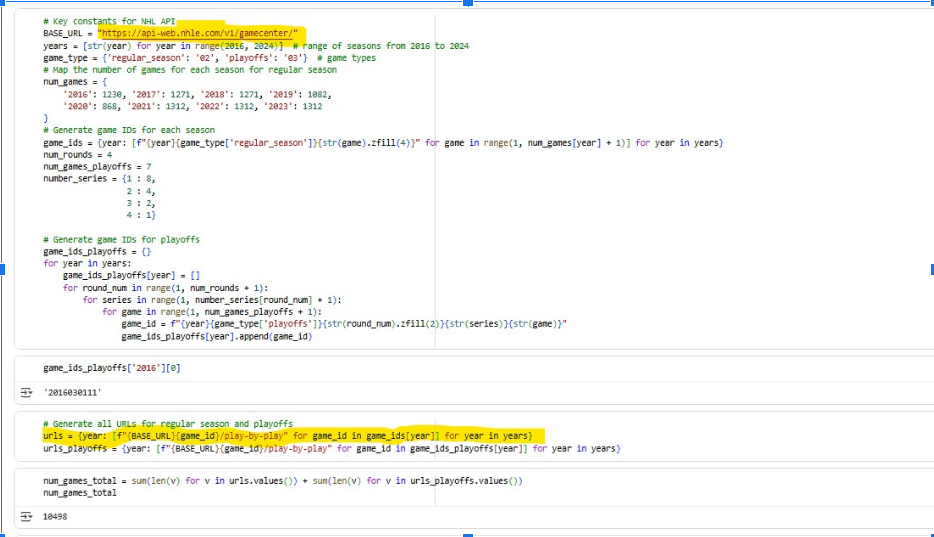

The NHL Stats API provides play-by-play data at: https://api-web.nhle.com/v1/gamecenter/[GAME_ID]/play-by-play where the GAME_ID will encode season, game type (regular season or playoffs), and game number. We built helper code to create GAME_IDs from the 2016-2017 to the 2023-2024 season for both the regular season and play-offs.

b) **Step 2: Explaining our Data Fetcher Class**

We then implemented a NHLDataFetcher which handles three primary tasks:
Extracting raw data from the NHL API
Processing JSON into pandas DataFrame
Looping through entire seasons of NHL data to build a combined data set of regular season and playoff games.

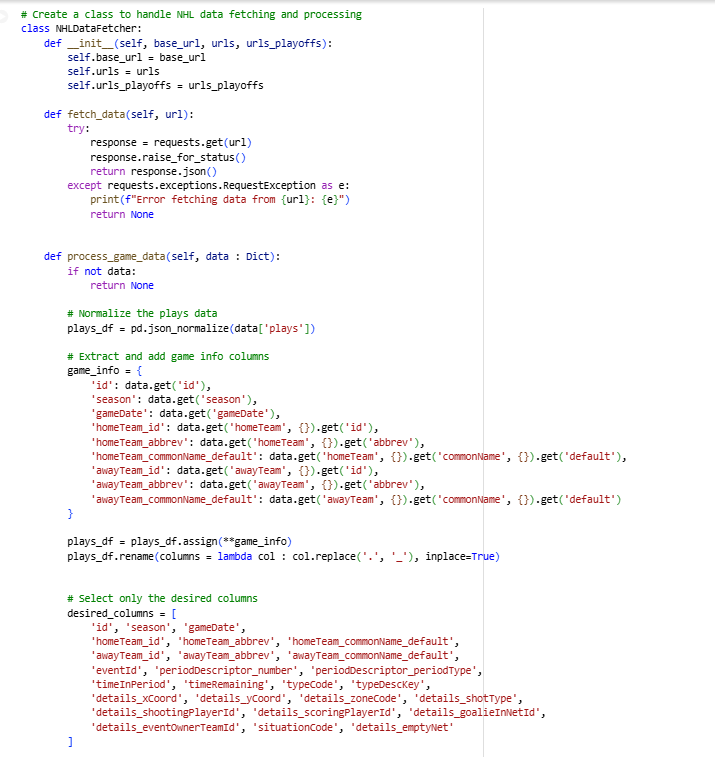

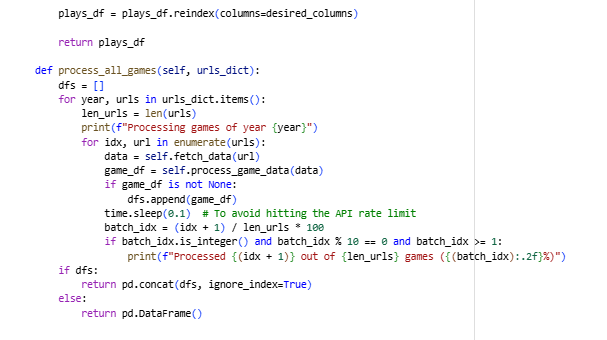


c) **Step 3: Using the developed NHL Class**

Once we establish this class the downloading and processing of the games is much more straightforward.

Extracting Data from a Single Game

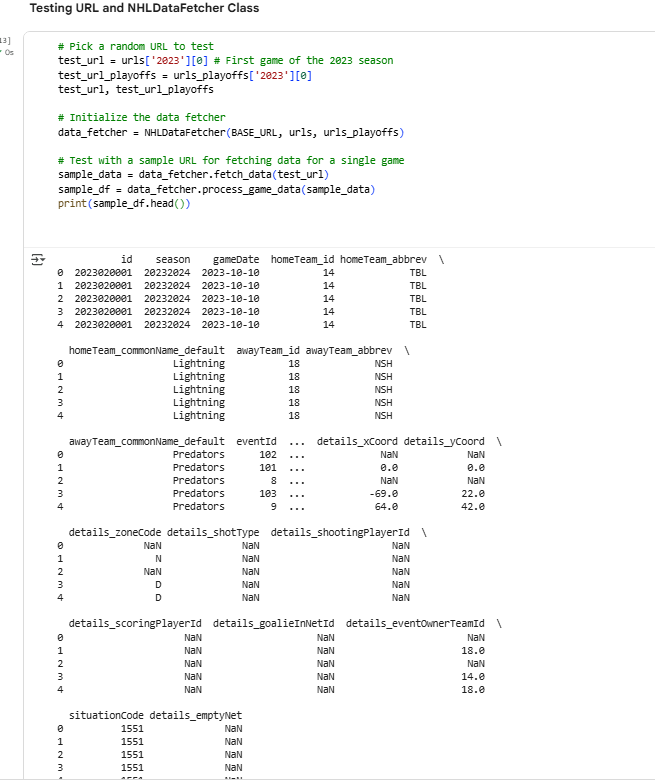



This will print a clean DataFrame with columns like gameDate, typeDescKey, details_Xcoord, and details_ycoord, amongst other issues.

Processing Data for an Entire Season

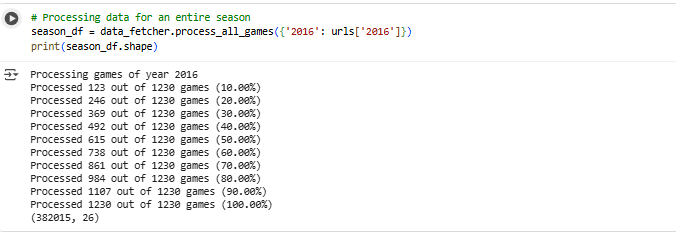

This now will give us thousands of rows of data (if we did not use .head()) for the 2016 season.

d)** Review of Key Design Choices**

i) **Class-based Approach:** This allows the code to be reusable to extract data from regular games and playoffs across multiple seasons.

ii) **Select usable columns:** Instead of keeping only raw JSON files where the files are all deeply nested, we keep only the most relevant columns like coordinates, player IDs, details_shotType, typeDescKey.

iii) **Extensibility:** This code can easily be developed to support other endpoints like more player statistics and team info.

In conclusion, when we structure our data around the NHLDataFetcher class, we developed a reproducible pipeline for downloading real-time NHL data that we can use for analysis. This foundation will enable running further data analysis and training machine learning models if necessary.


## **4. Tidy Data (Creating Pandas Dataframe)**

In [ ]:
# Creating Pandas Dataframe of NHL Data between 2016 - 2024 including both regular season games and playoffs
all_regular_season_df = data_fetcher.process_all_games(urls)
all_playoffs_df = data_fetcher.process_all_games(urls_playoffs)
all_games_df = pd.concat([all_regular_season_df, all_playoffs_df], ignore_index=True)
all_games_df.to_csv('nhl_all_games_data.csv', index=False)

**Exploration of pandas data frame using head(50)**

In [ ]:
all_games_df.head(50)

**Further Exploration of Pandas Dataframe**

In [ ]:
# Futher exploration of the data set
all_games_df['id'].nunique(), all_games_df['season'].nunique(), all_games_df['typeDescKey'].nunique()
all_games_df.info()
all_games_df.describe()

# **4. Tidy Data (Blog Post)**

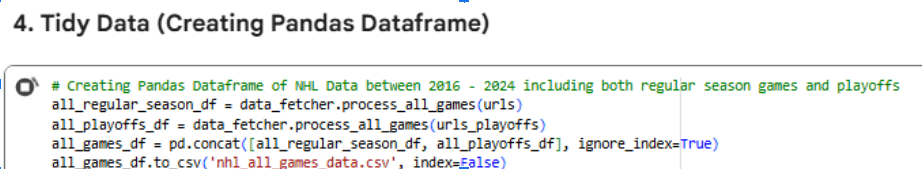
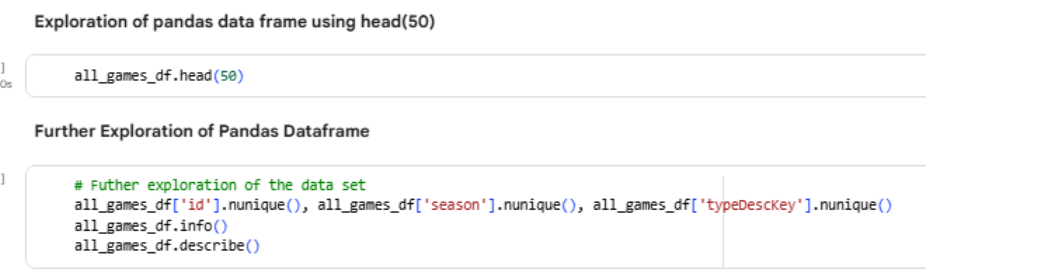

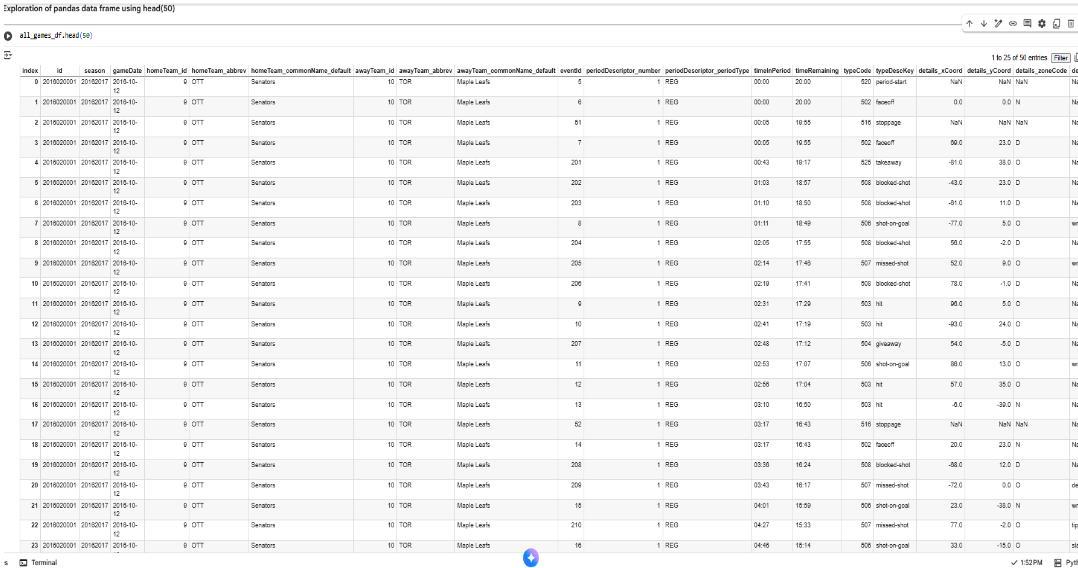
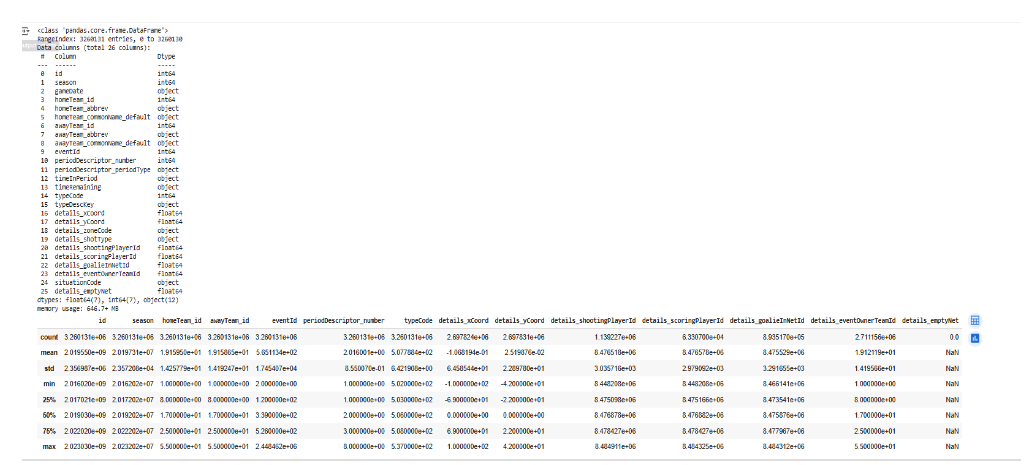

After we retrieved the 3.2 million play-by-play events for the NHL seasons between 2016 to 2024, we proceeded to consolidate these responses inside a JSON Data Frame. Within the data frame, each row represents a single event during the game. This could include details such as the game date, season, period, time, rink coordinates, shot type, and the teams involved in this said game. The resulting dataset (nhl_all_games_data.csv) provides a structured foundation for data analysis — making it much easier to visualize and model the data generated from the nhl games.

To continue the validation of the dataset, we used .info() and .describe() on the data frame. This confirmed 26 well-defined columns, consistent data types, and key statistical distributions for key numeric variables like coordinates (x, y) and player IDs. This again reinforces that our data is reliable and can be seen as a valid stepping stone for downstream analytics and system use.

The three new features we could add to further enhance the data set are rebound shots, shots off the rush, along with shot distance and angle metrics from the goal's position. The first of these features helps us check if a new shot occurred within a few seconds of another unsuccessful shot from a close coordinate.Shots off the rush help us understand whether or not a shot occurred soon after a change in puck possession (within 3 to 5 seconds). Lastly, the shot distance and angle metrics from the goal's position further helps us analyze player tendencies and shot quality. These additional features could enable deeper insights into how different goals are scored throughout different hockey game contexts.


# **2. Interactive Debugging Tool**

 **Section 2's code implements an ipywidget (or interactive tool of your choosing) that allows you to flip through all of the events, for every game of a given season, with the ability to switch between the regular season and playoffs.**

In [ ]:
# Importing necessary libraries for Interactive Debugging
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import ipywidgets as widgets
from ipywidgets import Dropdown
from IPython.display import clear_output, display

In [ ]:
# Creating rink image path and rink image
# df=pd.read_csv('nhl_all_games_data.csv')
import os
import matplotlib.image as mpimg

# Define filename (same name in both environments)
rink_filename = "rink.png"

# Case 1: Google Colab — check if running in Colab
try:
    import google.colab
    from google.colab import drive
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

# Detect base path
if IN_COLAB:
    # Mount Drive once (if not already mounted)
    drive.mount('/content/drive', force_remount=True)

    # Path where your file lives in Google Drive
    drive_path = "/content/drive/My Drive/Data Science Milestone 1/"
    rink_img_path = os.path.join(drive_path, rink_filename)

else:
    # Local (VS Code or GitHub)
    base_path = os.path.dirname(os.path.abspath(__file__)) if "__file__" in locals() else os.getcwd()
    rink_img_path = os.path.join(base_path, rink_filename)

# Load safely
try:
    rink_img = mpimg.imread(rink_img_path)
    print(f"Loaded rink image from: {rink_img_path}")
except FileNotFoundError:
    raise FileNotFoundError(f" Could not find rink.png at: {rink_img_path}")

In [ ]:
# Defining x, y, and etype columns
all_games_df = pd.read_csv("nhl_all_games_data.csv")

xcol, ycol = "details_xCoord", "details_yCoord"
etype_col = "typeDescKey" if "typeDescKey" in all_games_df.columns else ("typeDesc" if "typeDesc" in all_games_df.columns else "type")

# Function which defines drawing playing events
def draw_play_event(season, gameDate, event_id):
    clear_output(wait=True)

    # Defining the given nhl game
    df_game = all_games_df[(all_games_df['season'] == season) & (all_games_df['gameDate'] == gameDate)]
    # IF game is empty then no events for this game
    if df_game.empty:
        print("No events for this game")
        return
    # If event id is not in the game, then no event for game
    if event_id not in df_game['eventId'].unique():
        print(f"Event ID {event_id} not found in this game")
        return
    # Defining events
    df_event = df_game[df_game['eventId'] == event_id]
    # Defining coordinates
    df_coords = df_event.dropna(subset=[xcol, ycol])
    # Defining figures and axis
    fig, ax = plt.subplots(figsize=(10,6))
    ax.imshow(rink_img, extent=[-100,100,-42.5,42.5], zorder=0, aspect='auto')
    # IF coordinates are not empty then plot them with ax.scatter
    if not df_coords.empty:
      # Plotting with ax.scatter
        ax.scatter(df_coords[xcol], df_coords[ycol], c="blue", s=60, alpha=0.8, zorder=5)
        for _, row in df_coords.iterrows():
            label = f"{row.get(etype_col,'')} ({row.get('timeInPeriod','')})"
            ax.text(row[xcol]+2, row[ycol]+2, label, fontsize=8, color="black")
    # Setting axis limits and titles
    ax.set_xlim(-100,100)
    ax.set_ylim(-42.5,42.5)
    ax.set_aspect("equal")
    ax.set_title(f"{season} | {gameDate} | Event {event_id}", fontsize=14)
    plt.show()

    display(df_event.reset_index(drop=True))

# Defining widgets for season, game, and event slider
season_dd = widgets.Dropdown(options=sorted(all_games_df['season'].unique()), description="Season")
game_dd   = widgets.Dropdown(description="Game Date")
event_slider = widgets.SelectionSlider(description="Event ID", options=[0], value=0,
                                       continuous_update=False, layout=widgets.Layout(width="80%"))
# Function which allows you to update games
def update_games(*args):
    season_val = season_dd.value
    games = sorted(all_games_df[all_games_df['season']==season_val]['gameDate'].unique())
    game_dd.options = games
    if games:
        game_dd.value = games[0]
season_dd.observe(update_games, names="value")
# Function which updates events
def update_events(*args):
    season_val = season_dd.value
    game_val = game_dd.value
    df_game = all_games_df[(all_games_df['season']==season_val) & (all_games_df['gameDate']==game_val)]
    event_ids = sorted(df_game['eventId'].unique())
    if len(event_ids) > 0:
        event_slider.options = event_ids
        event_slider.value = event_ids[0]
    else:
        event_slider.options = [0]
        event_slider.value = 0
game_dd.observe(update_events, names="value")

out = widgets.interactive_output(
    draw_play_event,
    {"season": season_dd, "gameDate": game_dd, "event_id": event_slider}
)

# Calling updates games and update events function
update_games()
update_events()


ui = widgets.VBox([season_dd, game_dd, event_slider, out])
# Displaying ui
display(ui)

# **5. Simple Visualization Section**

**Code below shows the answers to Q1 for Section 5**

In [ ]:
## Importing key libraries for visualizations like matplotlib.pyplot and seaborn
import matplotlib.pyplot as plt
import seaborn as sns

# Adding in filters for a single season, selected 2021-2022
s_season = "20212022"
# Creating new data frame where season column is filtered to season 2021-2022
agdf_season = all_games_df[all_games_df['season']==int(s_season)]

# Further filtering the all_games_df_season by only keeping shots and goals
shots_gl = agdf_season[agdf_season["typeDescKey"].isin(["shot-on-goal", "missed-shot", "blocked-shot", "goal"])]

# Grouping by shot types and given shot description to make creating the visualizations easier, and creating a pivot table style output
grouped_shots = shots_gl.groupby(['details_shotType', 'typeDescKey']).size().unstack(fill_value=0)

# Calculating the Total Shots and % of shots which created goals (which could be a useful future metric)
grouped_shots["Number of Shots"] = grouped_shots.sum(axis=1)
grouped_shots["Successful Shots %"] = grouped_shots["goal"]/grouped_shots["Number of Shots"] * 100

# Plotting most dangerous and most common type of shots for 2021 to 2022 season
fig, ax1 = plt.subplots(figsize=(12, 8))
grouped_shots["Number of Shots"].plot(kind="bar",ax=ax1, color='orange', position=0, width=0.5, label="Number of Shots")

# Setting second y-axis for Successful Shots %
ax2 = ax1.twinx()
grouped_shots["Successful Shots %"].plot(kind="line", ax=ax2, color="blue", marker="o", label="Shot Success Rate %")

# Setting x and y axis labels, legends, and finally initializing the plot
ax1.set_xlabel("Type of Shot")
ax1.set_ylabel("Number of Shots", color="black")
ax2.set_ylabel("Successful Shot %", color="black")
ax1.set_title("Shot Attempts vs Shot Type Success Rate (for the NHL 2021-2022 Season)")
ax1.legend(loc="upper left", bbox_to_anchor=(1.05, 1))
ax2.legend(loc="lower left", bbox_to_anchor=(1.05, 0))
plt.show()


**Code for Section 5 Question 2**

In [ ]:
# Importing numpy
import numpy as np
import pandas as pd

# Function to calculate distance from shot to the goal
def calculate_distance(x, y):
    # Assume hockey goals are positioned at (89,0) or (-89,0), calculate the distance using Euclidean Distance between these goals
    # and return the minimum
    goal1 = np.sqrt((x - 89)**2 + (y - 0)**2)
    goal2 = np.sqrt((x + 89)**2 + (y - 0)**2)
    return np.minimum(goal1, goal2)

# Creating Distance Column on the Data Frame
all_games_df["distance"] = calculate_distance(all_games_df["details_xCoord"].values, all_games_df["details_yCoord"].values)

# Filtering only on Shots and Goals
shots_gl = all_games_df[all_games_df["typeDescKey"].isin(["shot-on-goal", "missed-shot", "blocked-shot", "goal"])].copy()

# Dividing Distances between shots and goals into bins of 5 ft
shots_gl.loc[:,"bin_distance"] = pd.cut(shots_gl["distance"], bins = np.arange(0, 100, 5))
shots_gl["season"] = shots_gl["season"].astype(str)

# Calculating the probability that a goal is scored per distance bin
probability = shots_gl[shots_gl["season"].isin(["20182019", "20192020", "20202021"])]
probability_goal = probability.groupby(["season", "bin_distance", "typeDescKey"]).size().unstack(fill_value=0)
probability_goal["Total"] = probability_goal.sum(axis=1)
probability_goal["Goal % of Shots"] = probability_goal["goal"]/probability_goal["Total"] * 100

# Creating pivot table where index is distance bin, columns are season, and the values are the Goal % of Shots
pivoted_probability = probability_goal.reset_index().pivot(index="bin_distance", columns="season", values="Goal % of Shots")
# Applying lambda function where we get the mid points of each of the distance intervals
pivoted_probability.index = pivoted_probability.index.to_series().apply(lambda i: i.mid)

# Plotting Line Graph for each of these three seasons
ax = pivoted_probability.plot(kind="line", marker= "x", figsize=(14,8))
# Plotting graph with x, y axis, and legend (labels) along with titles
plt.ylabel("Probability of Goal")
plt.xlabel("Distance from Hockey Goal (ft)")
plt.title("Probability of Goal compared to Distance of Shot between NHL Seasons (2018-2021)")
plt.legend(title="NHL Season")
plt.grid(alpha=0.3)
# Plot the graph
plt.show()



Code below shows the answers to Q3 for Section 5

In [ ]:
# Selecting 2018 to 2019 as season for analysis
season = "20182019"

# Filtering shots_gl for current season
shots_gl_season = shots_gl[shots_gl["season"]== season]

# Creating bins for distance for every 5 ft
shots_gl_season.loc[:,"bin_distance"] = pd.cut(shots_gl_season["distance"], bins = np.arange(0, 100, 5))

# Calculating successful hockey shots %
goal = shots_gl_season.groupby(["bin_distance", 'details_shotType', 'typeDescKey'],observed=True).size().unstack(fill_value=0)
goal["Total"] = goal.sum(axis=1)
goal["Goal %"] = goal["goal"]/goal["Total"] * 100

# Applying pivot
goal_pivot = goal.reset_index().pivot(index="bin_distance", columns="details_shotType", values="Goal %")

# Plotting bar plot and setting x and y labels along with legend
ax= goal_pivot.plot(kind="bar", figsize=(14,8))
plt.title("Distance from Net compared to Goal % broken down by Shot Type for NHL 2018-2019")
plt.xlabel("Distance from Hockey Goal (ft)")
plt.ylabel("% of Shots being Goals")
plt.legend(title="Shot Type")
plt.tight_layout()
plt.show()












# **5. Simple Visualizations (Blog Post)**

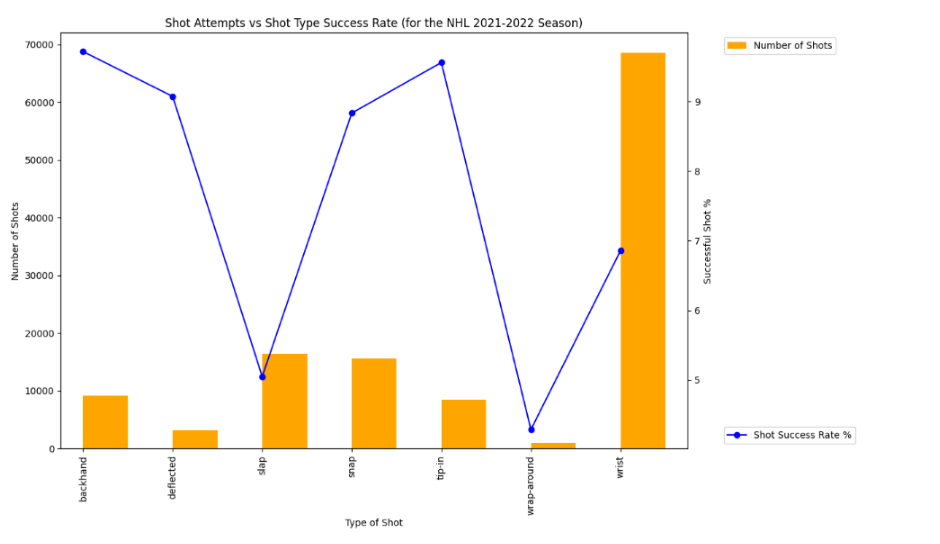

After analyzing the figure above which covers shot statistics for the NHL 2021-2022 season, we can see that the most dangerous shots are the backhand and tip-in (where backhand seems to have a slightly higher shot success rate %). Both of these shot types have a shot conversion rate of around 9.5%. According to the results of the graph above, we see that the most common shot type is wrist with around 70000 shots throughout the season. We chose this particular figure as bar charts with their thickness and height are good indicators to see the number of different types of shots throughout the hockey season. Additionally, a line chart was selected to show the Shot Success Rate % as a line chart would easily show the trend or general difference across the different types of shots. Note that these results make intuitive sense as wrist shots due to their ease and speed are the most commonly occurring in a hockey game, while backhand and tip-ins are taken close to the goal so are likely more dangerous to take.

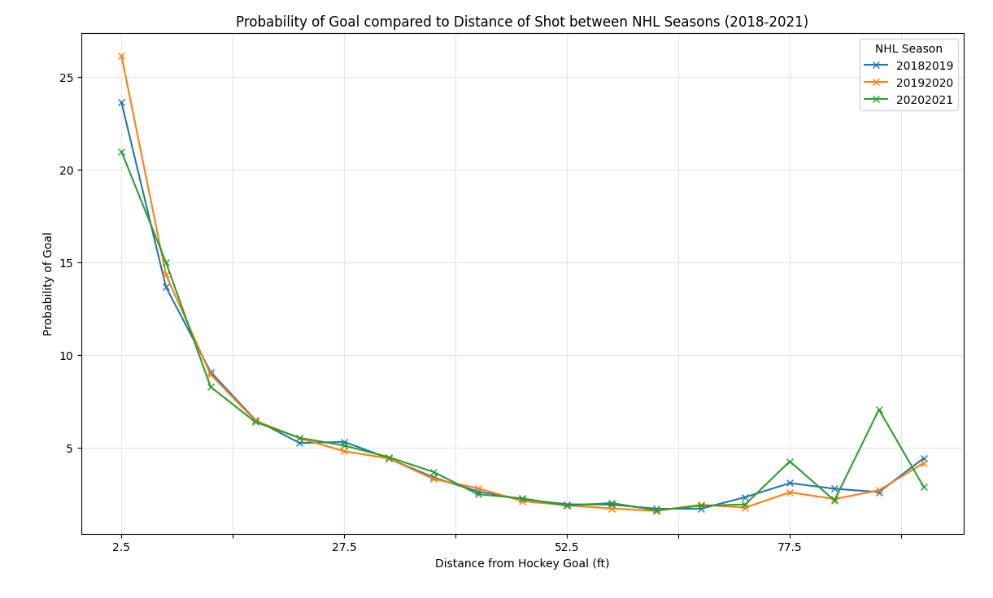

The above figure shows that across the three seasons from 2018 to 2021, the closer the distance the shot is from the goal, the probability of scoring the goal is much higher. Specifically, when you are 2.5 ft away from the goal, all three seasons have a probability of scoring of more than 20%. Additionally, when you have a shot that is more than 85 ft from the goal, the probability of a goal is less than 5%. Across the three seasons, the general trend of increasing the distance from the goal leads to a lower probability of scoring a goal is the same. However, the 2019-2020 season has the highest probability of scoring when you are around 2.5ft from the goal compared to the other two seasons. As you increase the distance though, the season with the highest to lowest probability of scoring a goal changes, however, the results are always close together (within only 3 to 4% of difference). A line graph was selected to show these figures as it is easy to use a line graph to see the trend for each season's probability of scoring a goal as the distance from the goal increases.
Overall, these results make intuitive sense as the farther you are away from a goal, the less likely you are to score.

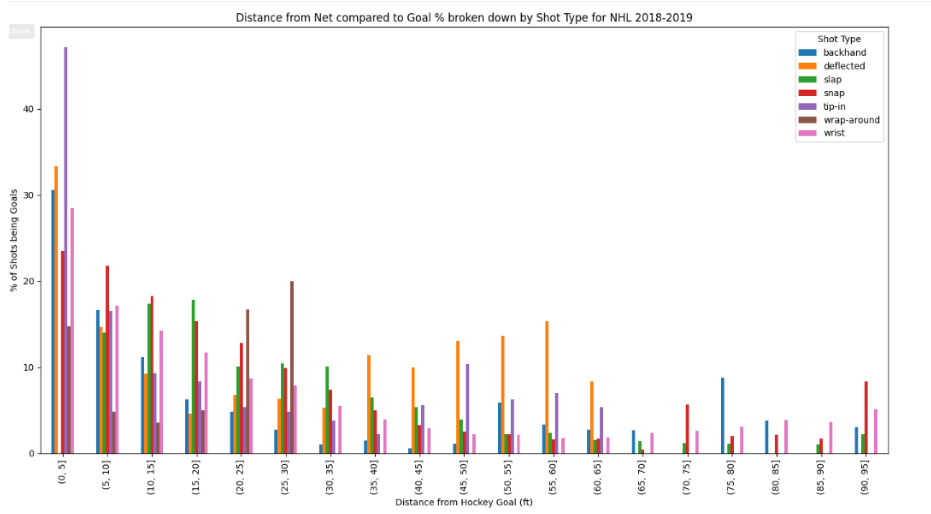

The figure above shows the goal percentage of various shot types compared to the distance from the hockey goal (ft) during the 2018-2019 season. When analyzing this data, we can observe several important trends expanded upon in more detail below.
When we are between 0 to 5 ft from the goal, tip-in (at over a 45% scoring rate) followed by deflected and backhand shots (with scoring both slightly above 30%) are the most dangerous shots. This result makes sense as both these types of the shot usually take place very close to the goal where the goalkeeper has less time to react and save the shot.
While the distance from the goal increases, the scoring % rate decreases for all types of shots. This decreases to on average less than 10% as we get from 40 to 45 ft from the goal. Between 30 to 65 ft from the goal, deflected shots have the highest success rate at scoring the goal at between 10 to 20%. Greater than 65 ft from the goal sees the most successful type of shot changing between snap shots, wrist shots, and backhand shots. Note though, these success rates for distances more than 60 ft from the goal all are 10% or less. Again, this intuitively makes sense as the farther you are from the goal, the less likely you are to score when you shoot.
Wrist shots are the most common type of shot shown throughout the figure. However, wrist shots have a lower success rate within 5 ft to the goal compared to more dangerous shots like tip-in, backhand, and deflected shots.
We selected a bar chart grouped by different shot types as the figure to analyze this question as it is easy for us to use a bar chart to see the trend of % of shots being goals based on distance from the goal broken down by group type.


# **6. Advanced Visualization Section**

### Question 1

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import os
from sklearn.preprocessing import MinMaxScaler
from scipy.interpolate import griddata
from scipy.ndimage import gaussian_filter
from PIL import Image

In [ ]:
df = pd.read_csv("nhl_all_games_data.csv")
df_copy = df.copy()

# Removing the datapoints that have either x or y coordinates missing.
df = df[~(df["details_xCoord"].isna() | df["details_yCoord"].isna())]

In [ ]:
# Plotting the first 50 points of the df on the rink image (img.shape = (467, 1100, 4)).
scaler = MinMaxScaler(feature_range=(0, 1100))
df["details_xCoord"] = scaler.fit_transform(df[["details_xCoord"]])

scaler = MinMaxScaler(feature_range=(0, 467))
df["details_yCoord"] = scaler.fit_transform(df[["details_yCoord"]])

img = plt.imread("nhl_rink.png")
fig, ax = plt.subplots()
ax.imshow(img)
ax.scatter(df["details_xCoord"][:50], df["details_yCoord"][:50])
ax.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
# Scaling all points such that they can be displayed on a rink half and plotting them.
df.loc[df["details_xCoord"]>550, "details_xCoord"] -= 550
df = df.drop(df[df["details_xCoord"]<59].index)

fig, ax = plt.subplots()
ax.imshow(img)
ax.scatter(df["details_xCoord"][:50], df["details_yCoord"][:50])
ax.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
def preProcess(df: pd.DataFrame) -> pd.DataFrame:
    """
    This function performs preprocessing on the dataset to make it suitable for visualization.

    output: a processed dataframe.
    """
    scaler = MinMaxScaler(feature_range=(0, 90))
    df["details_xCoord"] = scaler.fit_transform(df[["details_xCoord"]])

    scaler = MinMaxScaler(feature_range=(-42.5, 42.5))
    df["details_yCoord"] = scaler.fit_transform(df[["details_yCoord"]])

    SHOT_TYPES = {'shot-on-goal', 'goal', 'missed-shot', 'blocked-shot'}
    df = df[df['typeDescKey'].isin(SHOT_TYPES)]

    return df

df = preProcess(df)

In [ ]:
def avgRate(df: pd.DataFrame) -> pd.DataFrame:
    """
    This function calculates average rate of shooting at each unique (x, y) position in the dataset.

    output: a dataframe consisting of only the column "rate".
    """
    df_temp = df.copy()
    n = df_temp["id"].nunique()
    df_temp = df_temp.groupby(["details_xCoord", "details_yCoord"]).count()
    df_temp = pd.DataFrame(df_temp.iloc[:, 0])
    df_temp.columns = ["rate"]
    df_temp /= n

    return df_temp

def team_id_mask(df: pd.DataFrame, team_name: str) -> pd.Series:
    """
    This function returns a boolean mask selecting shots made by the specified team.

    output: a boolean mask.
    """
    home = (df["homeTeam_commonName_default"] == team_name) & \
           (df["details_eventOwnerTeamId"] == df["homeTeam_id"])
    away = (df["awayTeam_commonName_default"] == team_name) & \
           (df["details_eventOwnerTeamId"] == df["awayTeam_id"])
    return home | away

def teamExcessRate(team: str, year: int, df: pd.DataFrame) -> pd.DataFrame:
    """
    This function calculates the excess shot rate of a team in the specified year.

    output: a one column dataframe consisting of the excess shot rates
    """
    df_season = df[(df.season == int(str(year)+str(year+1)))].copy()
    df_leagueRate = avgRate(df_season)/2

    df_team = df_season[team_id_mask(df_season, team)]
    df_teamRate = avgRate(df_team)
    df_excessRate = df_teamRate.sub(df_leagueRate, fill_value = 0)
    return df_excessRate

def shotMap(team : str, year : int, df: pd.DataFrame) -> np.array:

    '''
    This function computes the Z array representing the shot map.

    output: the z array of size number_x*number_y.
    '''

    #compute Z array
    df_rate = teamExcessRate(team, year, df)
    df_rate = df_rate.reset_index()
    [x,y] = np.round(np.meshgrid(np.linspace(0,90,91),np.linspace(-42.5,42.5,86)))
    z = griddata((df_rate['details_xCoord'], df_rate['details_yCoord']), df_rate['rate'], (x, y), method='cubic', fill_value=0)
    z = pd.DataFrame(z)*100
    #apply gaussian filter for smoothing
    z_smooth = gaussian_filter(z,sigma = 5)

    return z_smooth

def create_dropdown(team: str, teams, year: int) -> dict:
    '''
    This function creates the dropdown button of a team for a given year.

    output: a dictionnary containning the information of the dropdown button.
    '''

    return dict(label = team, method = 'update', args = [{'visible': [t == team for t in teams],
                             'title': team,
                             'showlegend': True},
                            {'title': {'text': team+' Season '+str(year)+'-'+str(year+1)}}])

def create_figure_year(year: int, df: pd.DataFrame) -> None:
    '''
    This function creates and displays the interactive offence shot map figure for a given year, and save it.

    output: None.
    '''
    fig = go.Figure()
    teams = sorted(df[df["season"] == int(str(year)+str(year+1))].homeTeam_commonName_default.unique())
    for team in teams:
        visible = False
        if team == teams[0]: visible = True
        z_smooth = shotMap(team, year, df)
        x = np.arange(0,90).astype(np.float32)
        y = np.arange(-42.5, 42.5).astype(np.float32)

        fig.add_trace(go.Contour(
                        z = z_smooth.T,
                        x = y, #invert xy so the plot is vertical
                        y = x,
                        colorscale=[[0, 'blue'], [0.5, 'white'], [1.0, 'red']],
                        opacity=0.4,
                        contours=dict(start=-1, end=1, size=0.1),
                        colorbar=dict(title=dict(text="Excess Shot Rate per Hour",
                                      font=dict(size=14, family="Arial, sans-serif"))),
                        visible = visible
                    ))
    fig['layout']['yaxis']['autorange'] = "reversed" #invert y axis so the plot shows relative distance to net
    fig['layout']['title']=teams[0]+' Season '+str(year)+'-'+str(year+1)
    fig['layout']['xaxis']['title']="Distance from Center of Rink (ft)"
    fig['layout']['yaxis']['title']="Distance from Net (ft)"
    fig.add_layout_image(
        dict(
            source=Image.open("nhl_rink_half.png"),
            xref="x",
            yref="y",
            x=-42.5,
            y=-11,
            sizex=85,
            sizey=101,
            opacity=1,
            sizing="stretch",
            layer="below"
        )
    )
    fig.update_xaxes(showgrid=False)
    fig.update_yaxes(showgrid=False)
    fig.update_layout(
        updatemenus=[go.layout.Updatemenu(
            active = 0,
            buttons = [create_dropdown(team, teams, year) for team in teams]
            )
        ],
        showlegend=False,
        width=910,
        height=630,
        autosize=False,
        margin=dict(t=40, b=0, l=0, r=0),
        template="plotly_white",
    )
    fig.show()
    if not os.path.exists("./html"):
        os.makedirs("./html")
    fig.write_html("./html/shotMap"+str(year)+".html")
    return None

### Question 2
From the figures below, we can see the areas where the teams made most of their shots, revealing potential weaknesses in the opposing defenses. They also illustrate how each team’s offensive effectiveness evolved across different seasons.

In [ ]:
create_figure_year(2016, df)

In [ ]:
create_figure_year(2017, df)

In [ ]:
create_figure_year(2018, df)

In [ ]:
create_figure_year(2019, df)

In [ ]:
create_figure_year(2020, df)

### Question 3
In 2016-17, we can see that compared to the league average shooting rate, Avalanch performed worse in most areas, evident by the larger blue areas in the plot. On the contrary, in 2020-21 the plot is dominated by red areas, i.e., Avalanche made more shots in most spots of the rink.

This is validated by considering the change of the team's standing from last to first.

### Question 4
In 2018-19, the Tampa Bay Lightning was more dominant in the center while the Buffalo Sabres, weren't able to make many shots close to the goal.

In the next year, the heatmap of the Lightning was mostly the same, whereas the attack power of the Sabres diminished.

In 2020-21, the Lightning wasn't able to make shots as close as to the goal as previous years, and the Sabres remained mostly the same.

We can glean a lot of information about the offensive capabilities of one team or the defensive prowess of the other team, just by observing the excess shooting rate heat map.